In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from pygam import LinearGAM

In [ ]:
df_sub = pd.read_csv('top90.csv')
df_sub.isnull().sum() #check for null

Unnamed: 0                   0
year                         0
iso                          0
country_or_area              0
region                       0
continent                    0
number_of_disasters          0
total_human_affected         0
temperature                  0
precipitation                0
cropland                     0
country_area                 0
cropland_pct                 0
variant                      0
population                   0
rice_production_in_tonnes    0
dtype: int64

In [ ]:
df_sub.info()
df_sub.year.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 728 non-null    int64  
 1   year                       728 non-null    int64  
 2   iso                        728 non-null    object 
 3   country_or_area            728 non-null    object 
 4   region                     728 non-null    object 
 5   continent                  728 non-null    object 
 6   number_of_disasters        728 non-null    float64
 7   total_human_affected       728 non-null    float64
 8   temperature                728 non-null    float64
 9   precipitation              728 non-null    float64
 10  cropland                   728 non-null    float64
 11  country_area               728 non-null    float64
 12  cropland_pct               728 non-null    float64
 13  variant                    728 non-null    object 

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012])

In [ ]:
#Linear Regression
X = df_sub[['temperature','precipitation','cropland','number_of_disasters','total_human_affected']] 
y = df_sub['rice_production_in_tonnes']
X=sm.add_constant(X)        #to add constant value in the model
model= sm.OLS(y,X).fit()         #fitting the model
print(model.summary())    #summary of the model

                                OLS Regression Results                               
Dep. Variable:     rice_production_in_tonnes   R-squared:                       0.464
Model:                                   OLS   Adj. R-squared:                  0.460
Method:                        Least Squares   F-statistic:                     125.0
Date:                       Fri, 22 Oct 2021   Prob (F-statistic):           2.75e-95
Time:                               17:34:31   Log-Likelihood:                -13323.
No. Observations:                        728   AIC:                         2.666e+04
Df Residuals:                            722   BIC:                         2.669e+04
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

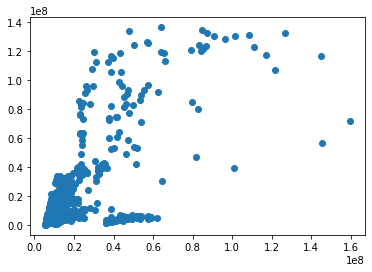

In [ ]:
#predictions
y_pred = model.predict(X)
plt.scatter(y_pred,y)

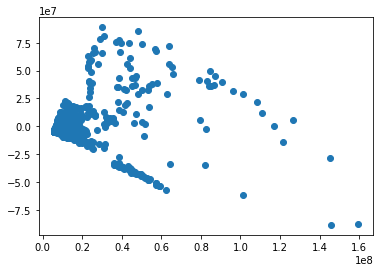

In [ ]:
#residual plot
res = model.resid
plt.scatter(y_pred,res)

In [ ]:
#Linear GAM model 
X = df_sub[['temperature','precipitation','cropland','number_of_disasters','total_human_affected']] 
gam = LinearGAM().fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.5497
Link Function:                     IdentityLink Log Likelihood:                                -23836.5888
Number of Samples:                          728 AIC:                                            47772.2769
                                                AICc:                                           47779.6714
                                                GCV:                                     75160101842927.88
                                                Scale:                                  66195158204397.516
                                                Pseudo R-Squared:                                   0.9282
Feature Function                  Lam

<ipython-input-14-c94702c7a7d1>:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Text(0, 0.5, 'Observed Rice Production (in tonnes)')

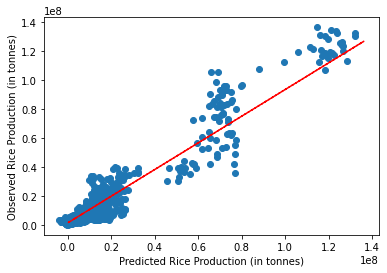

In [ ]:
#Predictions
predictions = gam.predict(X)

slope, intercept, r, p, std_err = stats.linregress(y, predictions) #add y=x line
linearpred = slope * y + intercept

plt.scatter(predictions,y)
plt.plot(y,linearpred,color='r', linestyle='dashed')
plt.xlabel("Predicted Rice Production (in tonnes)")
plt.ylabel("Observed Rice Production (in tonnes)")


Text(0, 0.5, 'Residual')

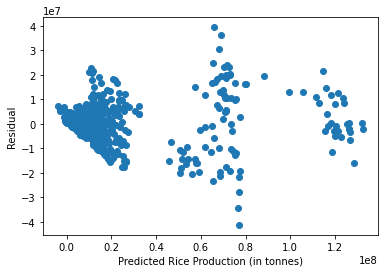

In [ ]:
#Residual plot
gamres = gam.deviance_residuals(X,y)
plt.scatter(predictions,gamres)
plt.xlabel("Predicted Rice Production (in tonnes)")
plt.ylabel("Residual")

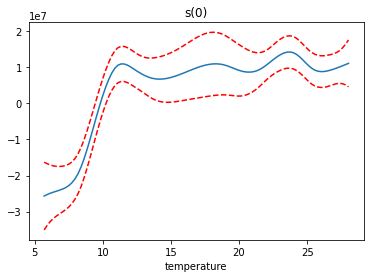

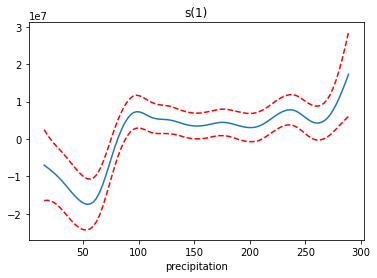

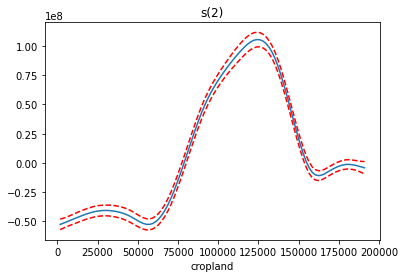

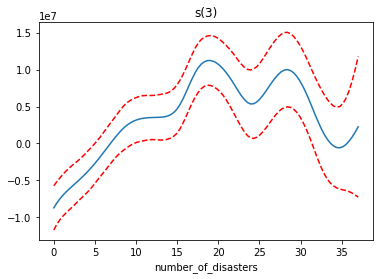

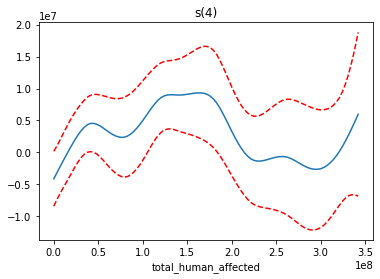

In [ ]:
# term functions for the GAM 
xlab = ['temperature','precipitation','cropland','number_of_disasters','total_human_affected']

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.xlabel(xlab[i])
    plt.show()

In [ ]:
#Panel Regressiom with Country and time effects
from linearmodels.panel import PanelOLS

df_sub=df_sub.set_index(["iso", "year"])
model = PanelOLS.from_formula("rice_production_in_tonnes ~ 1 + temperature + precipitation + cropland + number_of_disasters + total_human_affected + EntityEffects + TimeEffects",
                             data=df_sub)
result = model.fit(cov_type='clustered', cluster_entity=True,cluster_time=True)
result.summary

Dep. Variable:,rice_production_in_tonnes,R-squared:,0.2976
Estimator:,PanelOLS,R-squared (Between):,-1.0231
No. Observations:,728,R-squared (Within):,0.4153
Date:,"Fri, Oct 22 2021",R-squared (Overall):,-0.8383
Time:,18:01:30,Log-likelihood,-1.251e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,55.770
Entities:,14,P-value,0.0000
Avg Obs:,52.000,Distribution:,"F(5,658)"
Min Obs:,52.000,,
Max Obs:,52.000,F-statistic (robust):,6.4837


Text(0, 0.5, 'Observed Rice Production (in tonnes)')

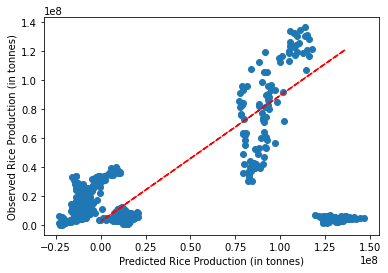

In [ ]:
#predictions
X2 = df_sub[['temperature','precipitation','cropland','number_of_disasters','total_human_affected']] 
y = df_sub['rice_production_in_tonnes']
X2=sm.add_constant(X2)        #to add constant value in the model
pre = result.predict(X2)
plt.scatter(pre,y)

slope, intercept, r, p, std_err = stats.linregress(y, pre['predictions']) #add y=x line
linearpred = slope * y + intercept

plt.plot(y,linearpred,color='r', linestyle='dashed')
plt.xlabel("Predicted Rice Production (in tonnes)")
plt.ylabel("Observed Rice Production (in tonnes)")

In [ ]:
result.variance_decomposition

Effects                   1.567084e+15
Residual                  5.034228e+13
Percent due to Effects    9.688751e-01
Name: Variance Decomposition, dtype: float64

Text(0, 0.5, 'Residual')

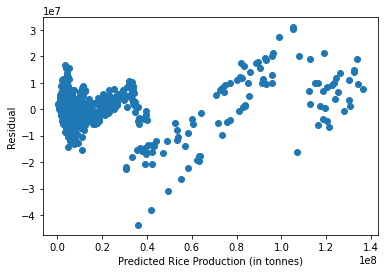

In [ ]:
#residual plot
res1 = result.resids
plt.scatter(y,res1)
plt.xlabel("Predicted Rice Production (in tonnes)")
plt.ylabel("Residual")

In [ ]:
#Pooled OLS
#df_sub=df_sub.set_index(["iso", "year"])
from linearmodels.panel import PooledOLS
m1 = PooledOLS.from_formula("rice_production_in_tonnes ~ 1 + temperature + precipitation + cropland + number_of_disasters",
                             data=df_sub)
result1 = m1.fit()
result1.summary

Dep. Variable:,rice_production_in_tonnes,R-squared:,0.3421
Estimator:,PooledOLS,R-squared (Between):,0.3344
No. Observations:,728,R-squared (Within):,0.3944
Date:,"Thu, Oct 21 2021",R-squared (Overall):,0.3421
Time:,00:22:00,Log-likelihood,-1.34e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,93.974
Entities:,14,P-value,0.0000
Avg Obs:,52.000,Distribution:,"F(4,723)"
Min Obs:,52.000,,
Max Obs:,52.000,F-statistic (robust):,93.974


In [ ]:
#Random Effects model
#df_sub=df_sub.set_index(["iso", "year"])
from linearmodels.panel import RandomEffects
m2 = RandomEffects.from_formula("rice_production_in_tonnes ~ 1 + temperature + precipitation + cropland + number_of_disasters+total_human_affected",
                             data=df_sub)
result2 = m2.fit()
result2.summary

Dep. Variable:,rice_production_in_tonnes,R-squared:,0.4215
Estimator:,RandomEffects,R-squared (Between):,0.2805
No. Observations:,728,R-squared (Within):,0.4460
Date:,"Fri, Oct 22 2021",R-squared (Overall):,0.3017
Time:,18:07:52,Log-likelihood,-1.266e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,105.20
Entities:,14,P-value,0.0000
Avg Obs:,52.000,Distribution:,"F(5,722)"
Min Obs:,52.000,,
Max Obs:,52.000,F-statistic (robust):,105.20


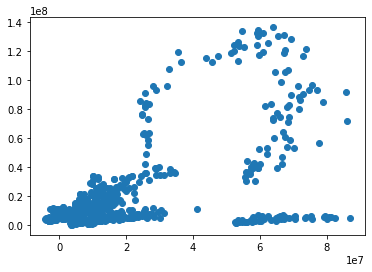

In [ ]:
#predictions
X2 = df_sub[['temperature','precipitation','cropland','number_of_disasters','total_human_affected']] 
y = df_sub['rice_production_in_tonnes']
X2=sm.add_constant(X2)        #to add constant value in the model
pred_re = result2.predict(X2)
plt.scatter(pred_re,y)

In [ ]:
from linearmodels.panel import compare

print(compare({"Panel": result, "RE": result2, "Pooled": result1}))

                                                 Model Comparison                                                
                                                Panel                            RE                        Pooled
-----------------------------------------------------------------------------------------------------------------
Dep. Variable               rice_production_in_tonnes     rice_production_in_tonnes     rice_production_in_tonnes
Estimator                                    PanelOLS                 RandomEffects                     PooledOLS
No. Observations                                  728                           728                           728
Cov. Est.                                   Clustered                    Unadjusted                    Unadjusted
R-squared                                      0.2935                        0.4713                        0.3421
R-Squared (Within)                             0.4206                        0.4805     

In [ ]:
#Panel Regressiom with Country and time effects
from linearmodels.panel import PanelOLS

#df_sub=df_sub.set_index(["iso", "year"])
model = PanelOLS.from_formula("rice_production_in_tonnes ~ 1 + temperature + precipitation + cropland + number_of_disasters + EntityEffects",
                             data=df_sub)
result = model.fit(cov_type='clustered', cluster_entity=True)
result.summary

Dep. Variable:,rice_production_in_tonnes,R-squared:,0.4815
Estimator:,PanelOLS,R-squared (Between):,-0.6561
No. Observations:,728,R-squared (Within):,0.4815
Date:,"Thu, Oct 21 2021",R-squared (Overall):,-0.5099
Time:,22:06:58,Log-likelihood,-1.256e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,164.82
Entities:,14,P-value,0.0000
Avg Obs:,52.000,Distribution:,"F(4,710)"
Min Obs:,52.000,,
Max Obs:,52.000,F-statistic (robust):,8.3813
